In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from astropy.cosmology import FlatLambdaCDM
from astropy import units as U
from scipy.constants import c
import sys
from math import pi
from astropy.cosmology import FlatLambdaCDM 
from matplotlib.animation import FuncAnimation


current_path = os.getcwd()
parent_dir = os.path.dirname(current_path)
print("Current working directory:", current_path)
print("Path to the parent directory:",parent_dir)

Current working directory: /home/sannino/ALMASim/experimental
Path to the parent directory: /home/sannino/ALMASim


In [21]:
def get_band_range(band):
    if band == 1:
        return (31, 45)
    elif band == 2:
        return (67, 90)
    elif band == 3:
        return (84, 116)
    elif band == 4:
        return (125, 163)
    elif band == 5:
        return (163, 211)
    elif band == 6:
        return (211, 275)
    elif band == 7:
        return (275, 373)
    elif band == 8:
        return (385, 500)
    elif band == 9:
        return (602, 720)
    elif band == 10:
        return (787, 950)

def get_band_central_freq(band):
    """
    Takes as input the band number and returns its central frequency in GHz
    """
    if band == 1:
        return 38
    elif band == 2:
        return 78.5
    elif band == 3:
        return 100
    elif band == 4:
        return  143
    elif band == 5:
        return  217
    elif band == 6:
        return 250
    elif band == 7:
        return 353
    elif band == 8:
        return 545
    elif band == 9:
        return 650
    elif band == 10:
        return 850


In [22]:

def read_line_emission_csv(path_line_emission_csv):
    """
    Read the csv file in which are stored the line emission's rest frequency.
    
    Parameter: 
    path_line_emission_csv (str): Path to file.csv within there are the line emission's rest frequency.
    
    Return:
    pd.DataFrame : Dataframe with line names and rest frequencies.
    """
    db_line = pd.read_csv(path_line_emission_csv, sep = ",")
    return db_line


In [23]:

def sed_reading(type_, path, lum_infrared=None, redshift=None):
    cosmo = FlatLambdaCDM(H0=70 * U.km / U.s / U.Mpc, Tcmb0=2.725 * U.K, Om0=0.3)
    if type_ == "extended" or type_ == 'diffuse':
        file_path = os.path.join(path, 'SED_low_z_warm_star_forming_galaxy.dat')
        if redshift is None:
            redshift = 10**(-4)
        if lum_infrared is None: 
            lum_infrared = 1e+10 # luminosity in solar luminosities
    elif type_ == "point" or type_ == "gaussian":
        file_path = os.path.join(path, 'SED_low_z_type2_AGN.dat')
        if redshift is None:
            redshift = 0.05
        if lum_infrared is None:
            lum_infrared = 1e+9 # luminosity in solar luminosities
    else:
        return "Not valid type"
    # Compute luminosity distance in Mpc
    distance_Mpc = cosmo.luminosity_distance(redshift).value # distance in Mpc
    Mpc_to_cm = 3.086e+24 # Mpc to cm
    distance_cm = distance_Mpc * Mpc_to_cm # distance in cm  -XX
    solid_angle = 4 * pi  * distance_cm**2 # solid angle in cm^2 -XX
    so_to_erg_s = 3.846e+33 # Solar luminosity to erg/s -XX
    lum_infrared_erg_s = lum_infrared * so_to_erg_s # luminosity in erg/s -XX
    
    # Load the SED
    sed = pd.read_csv(file_path, sep="\s+")
    # Convert to GHz
    sed['GHz'] = sed['um'].apply(lambda x: (x* U.um).to(U.GHz, equivalencies=U.spectral()).value)
    # Re normalize the SED and convert to Jy from erg/s/Hz
    sed['Jy'] = lum_infrared_erg_s * sed['erg/s/Hz'] * 1e+23 / solid_angle
    #  Flux (Jy) =L (erg/s/Hz) * 10^23 /  * 4 pi d^2(cm)
    flux_infrared = lum_infrared_erg_s * 1e+23 / solid_angle # Jy * Hz 
    #flux_infrared_jy = flux_infrared  / (sed['GHz'].values * U.GHz).to(U.Hz).value  # Jy
    sed.drop(columns=['um', 'erg/s/Hz'], inplace=True)
    sed = sed.sort_values(by='GHz', ascending=True) 
    return sed, flux_infrared

sed_point, flux_infrared_point = sed_reading("point", os.path.join(parent_dir, 'brightnes'), lum_infrared=1e+12, redshift=0.05)
sed_extended, flux_infrared_ext = sed_reading("extended", os.path.join(parent_dir, 'brightnes'), lum_infrared=1e+12, redshift=1e-4)
alma_bands = [get_band_range(i) for i in range(1, 11)]
color_map = plt.colormaps.get_cmap('tab10')


In [24]:

def cont_finder(cont_frequencies,line_frequency):
    #cont_frequencies=sed['GHz'].values
    distances = np.abs(cont_frequencies - np.ones(len(cont_frequencies))*line_frequency)
    return np.argmin(distances)

redshift = 0.2
band = 6
# Get band Central Frequency
central_frequency = get_band_central_freq(band)
# Load Line Database
db_line = read_line_emission_csv(os.path.join(parent_dir,'brightnes','temporary_update.csv'))
# Shift the SED to the given redshift
sed_point['GHz'] = sed_point['GHz'] * (1 + redshift)
# Get limits of the ALMA Band
freq_min, freq_max = alma_bands[band][0], alma_bands[band][1]
# Shift Line Frequencies with Redshift
db_line['shifted_freq(GHz)'] = db_line['freq(GHz)'] * (1 + redshift)
# Select lines that fall in the ALMA Band
line_mask = (db_line['shifted_freq(GHz)'].astype(float) >= freq_min) & (db_line['shifted_freq(GHz)'].astype(float) <= freq_max)
filtered_lines = db_line[line_mask]
# Select continuum frequencies that fall in the ALMA Band
cont_mask = (sed_point['GHz'] >= freq_min) & (sed_point['GHz'] <= freq_max)
cont_fluxes = sed_point[cont_mask]['Jy'].values
cont_frequencies = sed_point[cont_mask]['GHz'].values

line_names = filtered_lines['Line'].values
cs = filtered_lines['c'].values
cdeltas = filtered_lines['err_c'].values
line_ratio = np.array([np.random.normal(c, cd) for c, cd in zip(cs, cdeltas)])
# Get the index of the continuum where the line fall
line_indexes = filtered_lines['shifted_freq(GHz)'].apply(lambda x: cont_finder(cont_frequencies, float(x)))
# Line Flux (integrated over the line) = Cont_flux + 10^(log(L_infrared / line_width_in_Hz) + c)
line_frequencies =  filtered_lines['shifted_freq(GHz)'].values 
line_rest_frequencies = filtered_lines['freq(GHz)'].values * U.GHz
#fwhms = [np.random.randint(3, 10) for i in range(len(line_frequencies))] 
def generate_fwhms(line_frequencies, source : str):
    fwhms = []

    for i in range(len(line_frequencies)):
        if source == "gaussian":
            # Gaussian 
            mean_sigma = 60  # km/s 
            std_dev_sigma = 5  # km/s 
            random_sigma = np.random.normal(loc=mean_sigma, scale=std_dev_sigma)
            fwhm = 2 * np.sqrt(2 * np.log(2)) * random_sigma # km/s
        

        elif source == "pointed":
            # Pointed 
            mean_sigma = 70  # km/s 
            std_dev_sigma = 5  # km/s 
            random_sigma = np.random.normal(loc=mean_sigma, scale=std_dev_sigma)
            fwhm = 2 * np.sqrt(2 * np.log(2)) * random_sigma # km/s
          

        elif source == "extended":
            # Extended 
            mean_sigma = 150  # km/s 
            std_dev_sigma = 10  # km/s 
            random_sigma = np.random.normal(loc=mean_sigma, scale=std_dev_sigma)
            fwhm = 2 * np.sqrt(2 * np.log(2)) * random_sigma # km/s
        

        elif source == "disperse":
            # Disperse 
            mean_sigma = 300  # km/s 
            std_dev_sigma = 20  # km/s 
            random_sigma = np.random.normal(loc=mean_sigma, scale=std_dev_sigma)
            fwhm = 2 * np.sqrt(2 * np.log(2)) * random_sigma # km/s
            
   
        fwhms.append(int(np.isscalar(fwhm)))   # Append as float object

    return fwhms

fwhms = generate_fwhms(line_frequencies, 'gaussian')
freq_steps = np.array([cont_frequencies[line_index + fwhm] - cont_frequencies[line_index] for fwhm, line_index in zip(fwhms, line_indexes)]) * U.GHz
freq_steps = freq_steps.to(U.Hz).value
print(f'FWHM = {freq_steps}')
line_fluxes = cont_fluxes[line_indexes] + 10**(np.log10(flux_infrared_point ) + cs) / freq_steps
n_channels = 1024
new_cont_freq = np.linspace(freq_min, freq_max, n_channels)
if len(cont_fluxes) > 1: 
    cont_fluxes = np.interp(new_cont_freq, cont_frequencies, cont_fluxes)
else:
    cont_fluxes = np.ones(n_channels) * cont_fluxes[0]
line_indexes = filtered_lines['shifted_freq(GHz)'].apply(lambda x: cont_finder(new_cont_freq, float(x))).values
print(f'Line Indexes on continiuum: {line_indexes}')
print(f'Line fluxes {line_fluxes}')


FWHM = [1.53194105e+09 2.01944858e+09 1.76833061e+09 1.95330505e+09
 1.80808949e+09 1.77848247e+09 1.85892908e+09 1.73957774e+09
 1.89006564e+09]
Line Indexes on continiuum: [ 17 936 460 811 536 481 631 411 690]
Line fluxes [0.10249947        nan        nan 0.01934472 0.01584916 0.01753291
        nan 0.02735           nan]


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


Mean Continum: 0.015089936202578575
Line CO(2–1)a has a flux of 0.10249946971228951
Line SiO(7–6) has a flux of nan
Line HCN(3–2) has a flux of nan
Line CS(6–5) has a flux of 0.019344720596156866
Line HNC(3–2) has a flux of 0.01584916258260661
Line HCO+(3–2) has a flux of 0.017532908615147905
Line N2H+(3–2) has a flux of nan
Line CCH(3–2) has a flux of 0.027350002014169306
Line H28α has a flux of nan


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


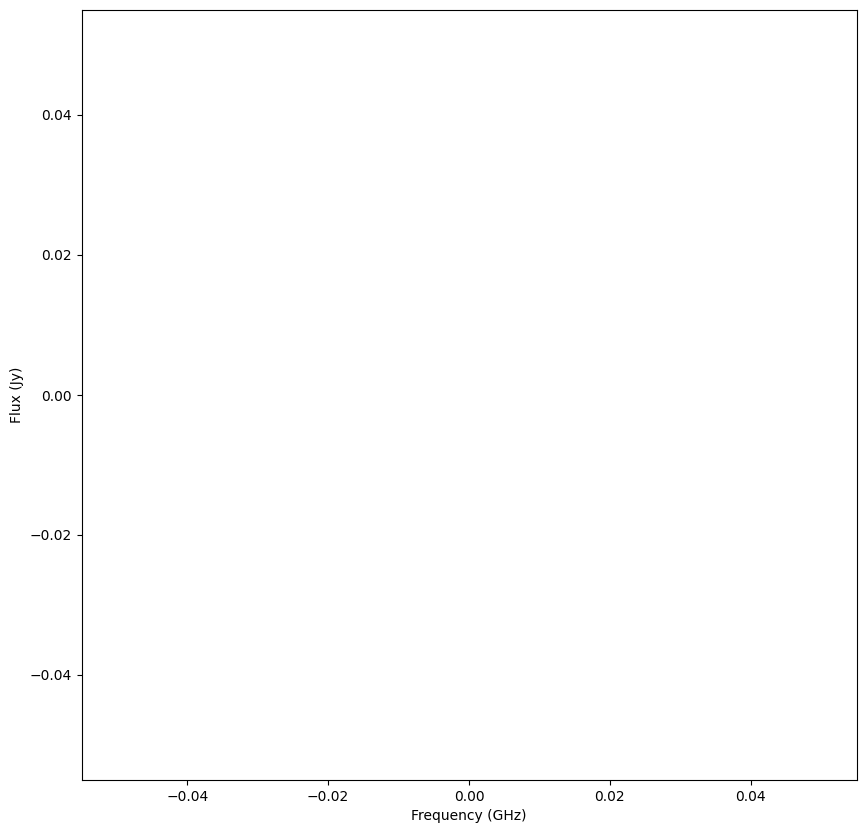

In [25]:

def gaussian(x, amp, cen, fwhm):
    """
    Generates a 1D Gaussian given the following input parameters:
    x: position
    amp: amplitude
    fwhm: fwhm
    """
    #def integrand(x, amp, cen, fwhm):
    #    return np.exp(-(x-cen)**2/(2*(fwhm/2.35482)**2))
    #integral, _ = quad(integrand, -np.inf, np.inf, args=(1, cen, fwhm))
    gaussian = np.exp(-(x-cen)**2/(2*(fwhm)**2))
    if np.sum(gaussian) != 0:
        norm = amp /  np.sum(gaussian)
    else:
        norm = amp
    result = norm * gaussian
    #norm = 1 / integral
    return result
z_idxs = np.arange(0, n_channels)
gs = np.zeros(n_channels)
for i in range(len(line_fluxes)):
    gs += gaussian(z_idxs, line_fluxes[i],  line_indexes[i], fwhms[i])

print('Mean Continum: {}'.format(np.mean(cont_fluxes)))
for flux, name in zip(line_fluxes, line_names):
    print('Line {} has a flux of {}'.format(name, flux))
spectrum = cont_fluxes + gs
plt.figure(figsize=(10, 10))
plt.plot(new_cont_freq, spectrum)
for freq, name, index in zip(line_frequencies, line_names, line_indexes):
    plt.text(new_cont_freq[index + 1], spectrum[index] + 0.001 * spectrum[index], name, rotation=0, verticalalignment='bottom')  # Add text annotation
plt.xlabel('Frequency (GHz)')
plt.ylabel('Flux (Jy)')
plt.savefig(os.path.join(parent_dir, 'experimental/sed_plot.png'))


In [26]:

def luminosity_to_jy(velocity, data,  redshift):
    
        """
        This function takes as input a pandas db containing luminosities in K km s-1 pc2, redshifts, and luminosity distances in Mpc, 
        and returns the brightness values in Jy.
        
        Parameters:
        velocity (float): The velocity dispersion assumed for the line (Km s-1).
        data (pandas.DataFrame): A pandas DataFrame containing the data.
        rest_frequency (float): The rest frequency of the line in GHz. Defaults to 115.27 GHz for CO(1-0).

        Output:
        sigma: numpy.ndarray: An array of brightness values in Jy.

        """
        alpha = 3.255 * 10**7 / 10**9
        cosmo = FlatLambdaCDM(H0=70 * U.km / U.s / U.Mpc, Tcmb0=2.725 * U.K, Om0=0.3)
        # Intensity: 10^9 K km s−1 pc2
        sigma = (data['Intensity'] * ( (1 + redshift) * data['freq(GHz)'] **2)) / (alpha * velocity * cosmo.luminosity_distance(redshift).value**2)
        return sigma


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


Mean Continum: 0.015089936202578575
Line CO(2–1)a has a flux of 11.185701167582344
Line SiO(7–6) has a flux of -0.15363642287678458
Line HCN(3–2) has a flux of -0.6421890033411906
Line CS(6–5) has a flux of 0.07183909487441073
Line HNC(3–2) has a flux of 0.10410759287455028
Line HCO+(3–2) has a flux of 0.3892564176170394
Line N2H+(3–2) has a flux of -1.1095202425367499
Line CCH(3–2) has a flux of 1.673107147666772
Line H28α has a flux of -0.15506233064182937


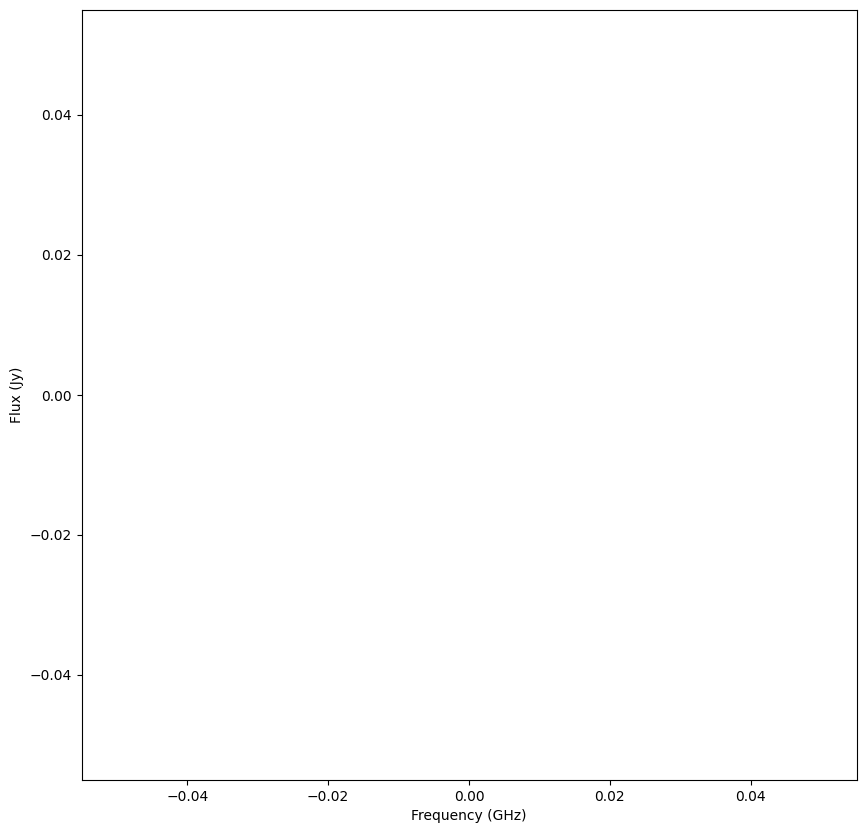

In [27]:

# Using the relation from Matteo's photo to convert K km s-1 pc2 in solar luminosity
def temperature_lum_to_solar_lum(data_path, freq_col_name, lum_col_name):
    db = pd.read_csv(data_path)
    temp_lum = db[lum_col_name] #luminosity values in k km s-1 pc2
    rest_freq = db[freq_col_name] #frequency at rest frame
    sol_lum= 3.2e-11 * (rest_freq ** 3)* (temp_lum * 1e9) #The matematical eq is: 3.2e-11 * ((obs_freq[GHz])*(1+z))^3 * L[k km s-1 pc2]
    #1e9 is presente because the data are presented in unit of 1e9 k km s-1 pc2, 
    return sol_lum #Line Luminosity values in unit of solar luminosity cfr. Spilker et all. 2014

new_lines = pd.read_csv(os.path.join(parent_dir,'brightnes','temporary_update.csv'))
new_lines['shifted_freq(GHz)'] = new_lines['freq(GHz)'] * (1 + redshift)
# Select lines that fall in the ALMA Band
line_mask2 = (new_lines['shifted_freq(GHz)'].astype(float) >= freq_min) & (new_lines['shifted_freq(GHz)'].astype(float) <= freq_max)
filtered_lines2 = new_lines[line_mask2]
line_name2= filtered_lines2['Line'].values
sigmas = luminosity_to_jy(60, filtered_lines2, redshift=0.2)
line_frequencies2 = filtered_lines2['freq(GHz)']
line_indexes2 = filtered_lines2['shifted_freq(GHz)'].apply(lambda x: cont_finder(new_cont_freq, float(x))).values
print('Mean Continum: {}'.format(np.mean(cont_fluxes)))
for flux, name in zip(sigmas, line_name2):
    print('Line {} has a flux of {}'.format(name, flux))
spectrum = cont_fluxes + gs
plt.figure(figsize=(10, 10))
plt.plot(new_cont_freq, spectrum)
for freq, name, index in zip(line_frequencies2, line_name2, line_indexes2):
    plt.text(new_cont_freq[index + 1], spectrum[index] + 0.001 * spectrum[index], name, rotation=0, verticalalignment='bottom')  # Add text annotation
plt.xlabel('Frequency (GHz)')
plt.ylabel('Flux (Jy)')
plt.show()


In [28]:
sigmas = luminosity_to_jy(60, new_lines, redshift=0.2)
df = pd.DataFrame({'Line Name': new_lines['Line'], 'Sigma': sigmas})
df

,Line Name,Sigma
0,CO(1–0)a,2.521129
1,CH,1.769359
2,CO(2–1)a,11.185701
3,OH 425,-0.196464
4,CO(3–2),19.651075
...,...,...
91,H26α,-0.079995
92,H27α,-0.089666
93,H28α,-0.155062
94,LiH(1–0),0.075650
